# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

In [1]:
'''
Import all required libraries and dependencies
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (Model, MultiprocessingEvaluator, SequentialEvaluator, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging)
from ema_workbench.em_framework.samplers import LHSSampler
from ema_workbench.em_framework.samplers import FullFactorialSampler as FFS


from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

from sklearn.preprocessing import StandardScaler
from statsmodels.regression.linear_model import OLS

C:\Conda\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


In [2]:
'''
Define predator prey function
'''
def pred_prey_py(prey_birth_rate=0.025, predation_rate=0.0015, predator_efficiency=0.002,
             predator_loss_rate=0.06, initial_prey=50, initial_predators=20, dt=0.25, 
             final_time=365, reps=1):

    #Initial values
    predators = np.zeros((reps, int(final_time/dt)+1))
    prey = np.zeros((reps, int(final_time/dt)+1))
    sim_time = np.zeros((reps, int(final_time/dt)+1))
    
    for r in range(reps):

        predators[r,0] = initial_predators
        prey[r,0] = initial_prey

    #Calculate the time series
    for t in range(0, sim_time.shape[1]-1):

        dx = (prey_birth_rate*prey[r,t]) - (predation_rate*prey[r,t]*predators[r,t])
        dy = (predator_efficiency*predators[r,t]*prey[r,t]) - (predator_loss_rate*predators[r,t])

        prey[r,t+1] = max(prey[r,t] + dx*dt, 0)
        predators[r,t+1] = max(predators[r,t] + dy*dt, 0)
        sim_time[r,t+1] = (t+1)*dt
    
    #Return outcomes
    return {'TIME':sim_time,
            'predators':predators,
            'prey':prey}

In [3]:
ema_logging.log_to_stderr(ema_logging.INFO) # turn on logging for ema_workbench

# Setup the model
pred_prey = Model('PredPreyPy', function=pred_prey_py)

pred_prey.uncertainties = [RealParameter('prey_birth_rate', 0.015, 0.035),
                       RealParameter('predation_rate', 0.0005, 0.003),
                      RealParameter('predator_efficiency', 0.0001, 0.004),
                      RealParameter('predator_loss_rate', 0.004, 0.08)]

pred_prey.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

In [4]:
'''
Run model with sequential evaluator as pred prey is not included as seperate .py file and thus wont work with multiprocessing
'''

with SequentialEvaluator(pred_prey) as evaluator:
    experiment, outcomes = evaluator.perform_experiments(scenarios = 200, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 200 scenarios * 1 policies * 1 model(s) = 200 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 140 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 180 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] experiments finished


In [5]:
'''
Convert outcomes to single variables per experiment for st. dev, final value and mean.
'''
df = pd.DataFrame(outcomes['prey'][:,-1])
df['std'] = df.T.std()
df['last'] = df[1460]
df['mean'] = np.mean(df)

In [6]:
'''
Store used variables in new dataframe.
'''
Y = df[['std', 'last', 'mean']].copy()




In [7]:
'''
Normalize input values as to be able to compare results of these variables.
'''

scale = StandardScaler()
X = experiment[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]
scaled_data = scale.fit_transform(X)
X = pd.DataFrame(X)

In [8]:
regression_model = OLS(Y['std'], scaled_data).fit()
regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    std   R-squared (uncentered):                   0.190
Model:                            OLS   Adj. R-squared (uncentered):              0.174
Method:                 Least Squares   F-statistic:                              11.53
Date:                Tue, 11 May 2021   Prob (F-statistic):                    2.00e-08
Time:                        14:26:35   Log-Likelihood:                         -1125.2
No. Observations:                 200   AIC:                                      2258.
Df Residuals:                     196   BIC:                                      2272.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             7.6252      4.837      1.577      0.117      -1.913      17.164
x2           -29.0750      4.853     -5.991      0.000     -38.647     -19.503
x3            14.7402      4.832      3.050      0.003       5.210      24.271
x4             0.8219      4.865      0.169      0.866      -8.773      10.417
==============================================================================
Omnibus:                      207.040   Durbin-Watson:                   1.574
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4463.298
Skew:                           4.185   Prob(JB):                         0.00
Kurtosis:                      24.577   Cond. No.                         1.21
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
regression_model = OLS(Y['mean'], scaled_data).fit()
regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   mean   R-squared (uncentered):                   0.001
Model:                            OLS   Adj. R-squared (uncentered):             -0.020
Method:                 Least Squares   F-statistic:                            0.04132
Date:                Tue, 11 May 2021   Prob (F-statistic):                       0.997
Time:                        14:26:35   Log-Likelihood:                         -975.35
No. Observations:                 200   AIC:                                      1959.
Df Residuals:                     196   BIC:                                      1972.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0094      2.286     -0.004      0.997      -4.518       4.499
x2            -0.0969      2.294     -0.042      0.966      -4.621       4.427
x3            -0.8805      2.284     -0.386      0.700      -5.385       3.624
x4             0.1592      2.300      0.069      0.945      -4.376       4.694
==============================================================================
Omnibus:                       31.184   Durbin-Watson:                   0.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.807
Skew:                           0.807   Prob(JB):                     1.51e-06
Kurtosis:                       2.218   Cond. No.                         1.21
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
regression_model = OLS(Y['last'], scaled_data).fit()
regression_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   last   R-squared (uncentered):                   0.207
Model:                            OLS   Adj. R-squared (uncentered):              0.191
Method:                 Least Squares   F-statistic:                              12.81
Date:                Tue, 11 May 2021   Prob (F-statistic):                    2.78e-09
Time:                        14:26:35   Log-Likelihood:                         -1211.7
No. Observations:                 200   AIC:                                      2431.
Df Residuals:                     196   BIC:                                      2445.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            19.2417      7.453      2.582      0.011       4.544      33.939
x2           -43.9555      7.478     -5.878      0.000     -58.704     -29.207
x3            26.1317      7.446      3.509      0.001      11.447      40.817
x4             3.8415      7.497      0.512      0.609     -10.943      18.626
==============================================================================
Omnibus:                      305.646   Durbin-Watson:                   1.590
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36713.149
Skew:                           7.057   Prob(JB):                         0.00
Kurtosis:                      67.857   Cond. No.                         1.21
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see that predator loss rate is important for the mean of the model.  Predator efficiency has the highest coefficient for the final state. 
Also we can see that the model goes to the extremes at the final state of the model as differences in end states is much bigger than the differences in the means.


In [11]:
'''
Run experiments with SOBOL sampling
'''

with SequentialEvaluator(pred_prey) as evaluator:
    experiment_SOBOL, outcomes_SOBOL = evaluator.perform_experiments(scenarios = 1000, uncertainty_sampling=SOBOL)

C:\Conda\lib\site-packages\SALib\sample\saltelli.py:52: FutureWarning: 
        Convergence properties of the Sobol' sequence is only valid if `N` = 2^n.
        SALib will continue on, but results may have issues.
        In future, this will raise an error.
        
  warnings.warn(msg, FutureWarning)
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished


In [12]:
'''
Convert outcomes to single variables per experiment for st. dev, final value and mean.
'''

df_SOBOL = pd.DataFrame(outcomes_SOBOL['prey'][:,-1])
df_SOBOL['std'] = df_SOBOL.T.std()
df_SOBOL['last'] = df_SOBOL[df_SOBOL.columns[-1]]
df_SOBOL['mean'] = np.mean(df_SOBOL, axis=1)
Y_SOBOL = df_SOBOL[['std', 'last', 'mean']]

X_SOBOL = experiment_SOBOL[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]


In [13]:
'''
Define SAlib problem
'''

SA_lib_problem = get_SALib_problem(pred_prey.uncertainties)

In [14]:
Si = sobol.analyze(SA_lib_problem, Y_SOBOL['mean'].to_numpy())

# Note
The second order effects are not in the plots, but are there. Especially the effect between the second and the third variable is there. So between predator_efficiency and predator_loss_rate. 

In [15]:
scores_filtered = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
scores_filtered

{'ST': array([0.00257692, 0.89458777, 0.29079579, 0.00975835]),
 'ST_conf': array([0.00124212, 0.15889193, 0.0906212 , 0.00401179]),
 'S1': array([-0.00145842,  0.68603644,  0.13200074,  0.00290268]),
 'S1_conf': array([0.00398725, 0.21141713, 0.0494404 , 0.00523696])}

In [16]:
Si_df = pd.DataFrame(scores_filtered, index= SA_lib_problem['names'])
Si_df

,ST,ST_conf,S1,S1_conf
predation_rate,0.002577,0.001242,-0.001458,0.003987
predator_efficiency,0.894588,0.158892,0.686036,0.211417
predator_loss_rate,0.290796,0.090621,0.132001,0.049440
prey_birth_rate,0.009758,0.004012,0.002903,0.005237


In [17]:
sns.set_style('white')

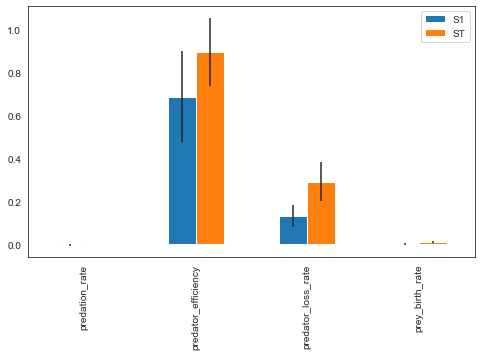

In [18]:
fig, ax = plt.subplots(1)
indices = Si_df[['S1', 'ST']]
err = Si_df[['S1_conf', 'ST_conf']]
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)

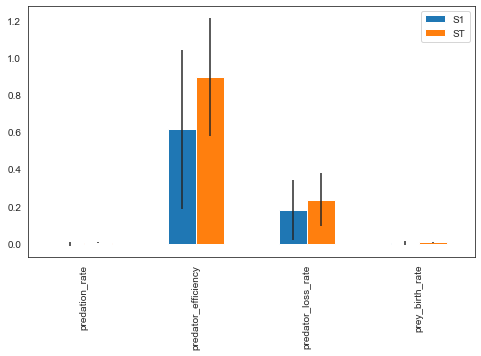

In [19]:
Si = sobol.analyze(SA_lib_problem, Y_SOBOL['mean'].to_numpy()[:2500])
scores_filtered = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index= SA_lib_problem['names'])

fig, ax = plt.subplots(1)
indices = Si_df[['S1', 'ST']]
err = Si_df[['S1_conf', 'ST_conf']]
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)

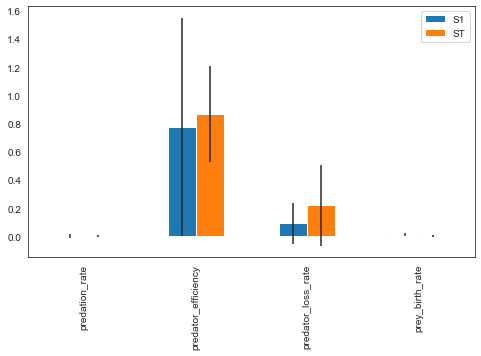

In [20]:
Si = sobol.analyze(SA_lib_problem, Y_SOBOL['mean'].to_numpy()[:500])
scores_filtered = {k:Si[k] for k in ['ST', 'ST_conf', 'S1', 'S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index= SA_lib_problem['names'])

fig, ax = plt.subplots(1)
indices = Si_df[['S1', 'ST']]
err = Si_df[['S1_conf', 'ST_conf']]
indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)

# Random Trees



In [21]:
with SequentialEvaluator(pred_prey) as evaluator:
    experiments_trees, outcomes_trees = evaluator.perform_experiments(scenarios = 400, uncertainty_sampling=LHS)


[MainProcess/INFO] performing 400 scenarios * 1 policies * 1 model(s) = 400 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 120 cases completed
[MainProcess/INFO] 160 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 240 cases completed
[MainProcess/INFO] 280 cases completed
[MainProcess/INFO] 320 cases completed
[MainProcess/INFO] 360 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] experiments finished


In [22]:
df = pd.DataFrame(outcomes_trees['prey'][:,-1])
df['std'] = df.T.std()
df['last'] = df[1460]
df['mean'] = np.mean(df, axis=1)
Y = df[['std', 'last', 'mean']]
X = experiments_trees[['predation_rate', 'predator_efficiency', 'predator_loss_rate', 'prey_birth_rate']]


In [23]:
rd_trees = feature_scoring.get_rf_feature_scores(X,Y,mode = RuleInductionType.REGRESSION,nr_trees=100, max_features=0.6)
rd_trees[0]

,1
0,
predator_efficiency,0.621637
predator_loss_rate,0.207081
predation_rate,0.089199
prey_birth_rate,0.082082


In [24]:
rd_trees[1]

RandomForestRegressor(max_features=0.6, oob_score=True)

<AxesSubplot:xlabel='0'>

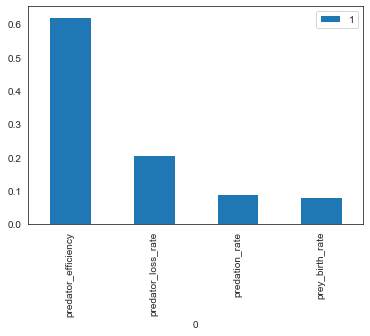

In [25]:
rd_trees[0].plot.bar()

It can be seen that the random trees compared to sobol both score high on predator effeciency. The other three factors also score lower in both analyses. So we can see that overall patterns are the same but that values in sobol are higher (this might be due to the random trees being limited to 0.6 for max_features).